# Preliminary Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

In [73]:
pd.set_option('display.max_rows',100)

# Importing Data

Dataset for socially rented dwelling by Local Authority, 1992-2021

In [2]:
df1 = pd.read_excel('Socially Rented Dwellings by LA, 1992-2021.xlsx')
df1.rename(columns={'new_dwellings':'SR'}, inplace=True)
df1.drop(columns='Unnamed: 0',inplace=True)
print(df1.shape)
df1.head()

(12000, 4)


,LA_code,LA,year,SR
0,E07000157,Alnwick,1992,44.0
1,E07000158,Berwick-upon-Tweed,1992,5.0
2,E07000159,Blyth Valley,1992,16.0
3,E07000160,Castle Morpeth,1992,8.0
4,E07000054,Chester-le-Street,1992,0.0


Dataset for total number of affordable dwellings by LA, 1992-2021

In [3]:
df2 = pd.read_excel('Affordable Rent Dwellings by LA, 1992-2021.xlsx')
df2.drop(columns='Unnamed: 0', inplace=True)
df2.rename(columns={'new_dwellings':'AR'}, inplace=True)
print(df2.shape)
df2.head()

(12000, 4)


,LA_code,LA,year,AR
0,E07000157,Alnwick,1992,45.0
1,E07000158,Berwick-upon-Tweed,1992,5.0
2,E07000159,Blyth Valley,1992,21.0
3,E07000160,Castle Morpeth,1992,8.0
4,E07000054,Chester-le-Street,1992,16.0


Total number of dwellings completed by Local Authority, 1980-2021

In [78]:
df3 = pd.read_excel('Dwellings by LA 1980-2021.xlsx')
df3.drop(columns=['Unnamed: 0','DLUHC Code','Former ONS Code'], inplace=True)
df3 = df3[['ONS Code','Local Authority','DC_Total','year']][df3.loc[:,'year']>=1992]
df3.reset_index(drop=True,inplace=True)
df3.rename(columns={'ONS Code':'LA_code','Local Authority':'LA'},inplace=True)

Importing data for median house price in UK by Local Authority, 1995-2021

In [5]:
df4 = pd.read_excel('Median House Prices by LA 1995-2021, Quarterly, Long.xlsx')


In [6]:
df4['quarter'] = df4['quarter'].map(lambda x: ''.join(x.split()))

In [7]:
df4 = df4.loc[df4.quarter!='...109',:]

In [8]:
df4['date'] = pd.to_datetime(df4['quarter'],format='%b%Y')

Merging all datasets into one

In [9]:
df = pd.merge(df1,df2,on=['LA_code','LA','year'])
df = pd.merge(df,df3,on=['LA_code','LA','year'])
df.loc[:,'date'] = pd.to_datetime(df.loc[:,'year'].astype(str),format='%Y')
df.loc[df.DC_Total=='..','DC_Total'] = np.nan
df.loc[:,'DC_Total'] = df.loc[:,'DC_Total'].astype(float)

In [10]:
df.head()

,LA_code,LA,year,SR,AR,DC_Total,date
0,E07000157,Alnwick,1992,44.0,45.0,140.0,1992-01-01
1,E07000158,Berwick-upon-Tweed,1992,5.0,5.0,70.0,1992-01-01
2,E07000159,Blyth Valley,1992,16.0,21.0,410.0,1992-01-01
3,E07000160,Castle Morpeth,1992,8.0,8.0,140.0,1992-01-01
4,E07000054,Chester-le-Street,1992,0.0,16.0,340.0,1992-01-01


Extracting data for Coventry alone

In [11]:
dcov = df[df.loc[:,'LA']=='Coventry'].copy()
dcov.head()

,LA_code,LA,year,SR,AR,DC_Total,date
109,E08000026,Coventry,1992,102.0,127.0,230.0,1992-01-01
408,E08000026,Coventry,1993,231.0,331.0,390.0,1993-01-01
707,E08000026,Coventry,1994,378.0,474.0,330.0,1994-01-01
1006,E08000026,Coventry,1995,271.0,371.0,490.0,1995-01-01
1305,E08000026,Coventry,1996,203.0,315.0,530.0,1996-01-01


In [12]:
dcov.reset_index(drop=True,inplace=True)

Filling in some missing values using external data and interpolation

In [ ]:
dcov.loc[13,'DC_Total'] = 140

In [ ]:
dcov['DC_Total'] = dcov['DC_Total'].interpolate()

# Visualisation

Plotting socially rented and affordable dwellings against total housing in Coventry, red line denotes housing need as assessed in Local Plan 2017 Housing SPD.

C:\Users\adnaa\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


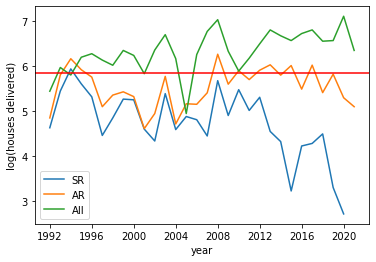

In [86]:
x = dcov['date']
y1 = np.log(dcov['SR'])
y2 = np.log(dcov['AR'])
y3 = np.log(dcov['DC_Total'])
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.axhline(y=np.log(348),color='r')
plt.xlabel('year')
plt.ylabel('log(houses delivered)')
plt.legend(['SR','AR','All'])

Note the fall in affordable housing since 2018, caused by?

Comparing Coventry affordable housing delivery against national average

In [87]:
dt = df[['LA_code','LA','SR','AR','DC_Total','date']].groupby(['date']).sum()

In [88]:
x = dt.index
y1 = dt['SR']
y2 = dt['AR']
y3 = dcov['SR']
y4 = dcov['AR']

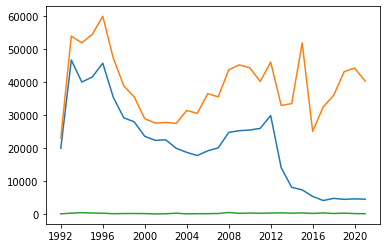

In [89]:
plt.plot(x,y1)
plt.plot(x,y2)
#plt.plot(x,y3)
plt.plot(x,y4)

Coventry is above the mean for affordable house delivery, but does not follow the recent trend of increasing affordable homes delivery.

Looking at relationship between house prices and housing supply. We compare changes in the median house price in Coventry with annual delivery of homes

In [90]:
dcov4 = df4[df4.loc[:,'LA']=='Coventry'].copy()
dcov4.reset_index(drop=True,inplace=True)
dcov4['year'] = dcov4['date'].dt.year

In [91]:
for x in dcov4.index[1:]:
    dcov4.loc[x,'price_change'] = dcov4.loc[x,'median'] - dcov4.loc[x-1,'median']

Lagged price change by 4 quarters

In [ ]:
for x in dcov4.index[4:]:
    dcov4.loc[x,'price_change_4'] = dcov4.loc[x-4,'price_change']

In [92]:
dcov4.head()

,LA_code,LA,quarter,median,date,year,price_change
0,E08000026,Coventry,Dec1995,42000.0,1995-12-01,1995,NaN
1,E08000026,Coventry,Mar1996,41500.0,1996-03-01,1996,-500.0
2,E08000026,Coventry,Jun1996,41500.0,1996-06-01,1996,0.0
3,E08000026,Coventry,Sep1996,42000.0,1996-09-01,1996,500.0
4,E08000026,Coventry,Dec1996,42000.0,1996-12-01,1996,0.0


C:\Users\adnaa\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


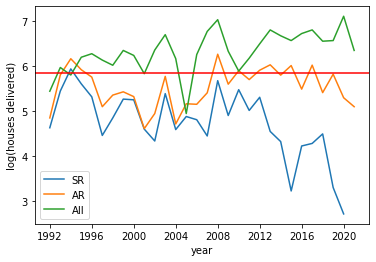

In [100]:
x = dcov['date']
y1 = np.log(dcov['SR'])
y2 = np.log(dcov['AR'])
y3 = np.log(dcov['DC_Total'])
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.axhline(y=np.log(348),color='r')
plt.xlabel('year')
plt.ylabel('log(houses delivered)')
plt.legend(['SR','AR','All'])

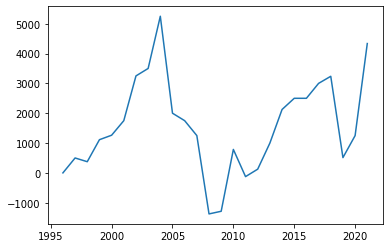

In [101]:
a = dcov4.groupby('year').mean().index
b = dcov4.groupby('year').mean().price_change
plt.plot(a,b)

It looks like as housing prices have risen, housing delivery has fallen. However, there is a lagged effect to housing supply's reaction to housing price changes. We can compare this by lagging house prices by a few periods

In [102]:
a = dcov4.groupby('year').mean().index
b = dcov4.groupby('year').mean().price_change_4

Text(0.5, 0.98, 'Housing Delivery and Housing Prices')

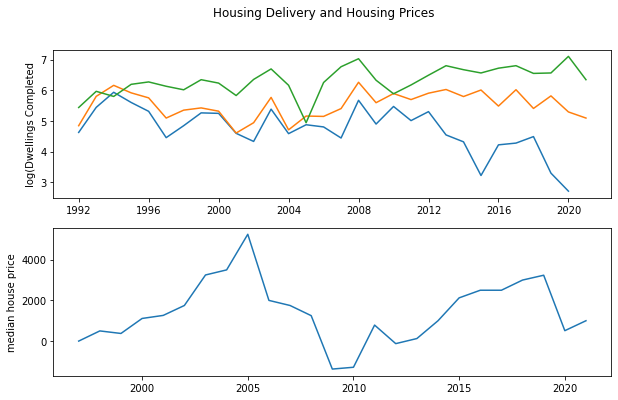

In [103]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,6))
ax[0].plot(x,y1)
ax[0].plot(x,y2)
ax[0].plot(x,y3)
ax[0].set(ylabel='log(Dwellings Completed')
ax[1].plot(a,b)
ax[1].set(ylabel='median house price')
fig.suptitle('Housing Delivery and Housing Prices')

In [62]:
from scipy.stats import pearsonr

0.3275348176721335


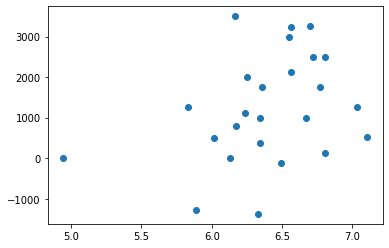

In [110]:
plt.scatter(y3[3:],b)
corr, _ = pearsonr(y3[5:],b[2:])
print(corr)

In [109]:
b[2005] = 0

Calculating correlation matrix between social rent and total dwellings

In [116]:
np.cov(dcov['SR'],dcov['DC_Total'])

array([[ 7888.56206897, -5735.20689655],
       [-5735.20689655, 62071.95402299]])

A negative relationship between number of total dwellings completed and socially rented homes delivered

In [118]:
np.cov(dcov['SR'],dcov['AR'])

array([[ 7888.56206897,  5063.73103448],
       [ 5063.73103448, 12537.91264368]])

A positive relationship between total number of affordable homes and socially rented homes, but obviously since socially rented homes are a subset of affordable homes, this is expected. Should see the relationship between socially rented homes and number of affordable rent homes.